# Tuning a scikit-learn estimator with `skopt`

Gilles Louppe, July 2016.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

## Problem statement

Tuning the hyper-parameters of a machine learning model is often carried out using an exhaustive exploration of (a subset of) the space all hyper-parameter configurations (e.g., using `sklearn.model_selection.GridSearchCV`), which often results in a very time consuming operation. 

In this notebook, we illustrate how `skopt` can be used to tune hyper-parameters using sequential model-based optimisation, hopefully resulting in equivalent or better solutions, but within less evaluations.

## Objective 

The first step is to define the objective function we want to minimize, in this case the cross-validation mean absolute error of a gradient boosting regressor over the Boston dataset, as a function of its hyper-parameters:

In [2]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

def objective(params):
    max_depth, learning_rate, max_features, min_samples_split, min_samples_leaf = params

    reg.set_params(max_depth=max_depth,
                   learning_rate=learning_rate,
                   max_features=max_features,
                   min_samples_split=min_samples_split, 
                   min_samples_leaf=min_samples_leaf)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1, scoring="mean_absolute_error"))

Next, we need to define the bounds of the dimensions of the search space we want to explore, and (optionally) the starting point:

In [3]:
space  = [(1, 5),                           # max_depth
          (10**-5, 10**-1, "log-uniform"),  # learning_rate
          (1, X.shape[1]),                  # max_features
          (2, 30),                          # min_samples_split
          (1, 30)]                          # min_samples_leaf

x0 = [3, 0.01, 6, 2, 1]

## Optimize all the things!

With these two pieces, we are now ready for sequential model-based optimisation. Here we compare gaussian process-based optimisation versus forest-based optimisation.

In [4]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

In [5]:
"Best score=%.4f" % res_gp.fun

'Best score=3.0168'

In [6]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- max_depth=2
- learning_rate=0.100000
- max_features=5
- min_samples_split=30
- min_samples_leaf=1


In [7]:
from skopt import forest_minimize
res_forest = forest_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

In [8]:
"Best score=%.4f" % res_forest.fun

'Best score=2.8968'

In [9]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_forest.x[0], res_forest.x[1], 
                            res_forest.x[2], res_forest.x[3], 
                            res_forest.x[4]))

Best parameters:
- max_depth=4
- learning_rate=0.094372
- max_features=5
- min_samples_split=20
- min_samples_leaf=1


As a baseline, let us also compare with random search in the space of hyper-parameters, which is equivalent to `sklearn.model_selection.RandomizedSearchCV`.

In [10]:
from skopt import dummy_minimize
res_dummy = dummy_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

In [11]:
"Best score=%.4f" % res_dummy.fun

'Best score=3.0592'

In [12]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.4f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_dummy.x[0], res_dummy.x[1], 
                            res_dummy.x[2], res_dummy.x[3], 
                            res_dummy.x[4]))

Best parameters:
- max_depth=5
- learning_rate=0.0596
- max_features=10
- min_samples_split=23
- min_samples_leaf=1


## Convergence plot

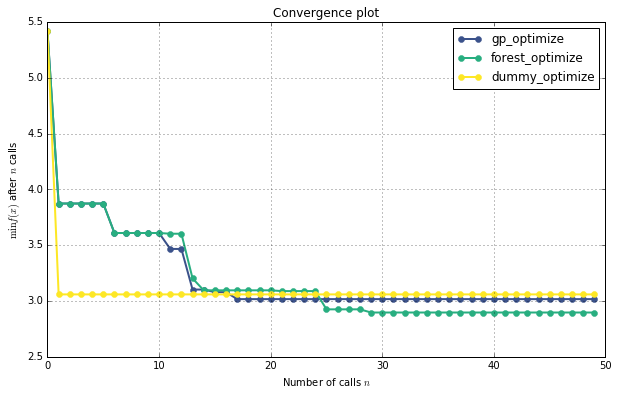

In [13]:
from skopt.plots import plot_convergence
plot_convergence(("gp_optimize", res_gp),
                 ("forest_optimize", res_forest),
                 ("dummy_optimize", res_dummy))